In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
dataset_path = 'dataset/chest_xray'

In [3]:
img_width, img_height = 150, 150
batch_size = 32

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # 'binary' for binary classification
    shuffle=True
)

Found 5216 images belonging to 2 classes.


In [6]:
validation_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'val'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 16 images belonging to 2 classes.


In [7]:
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


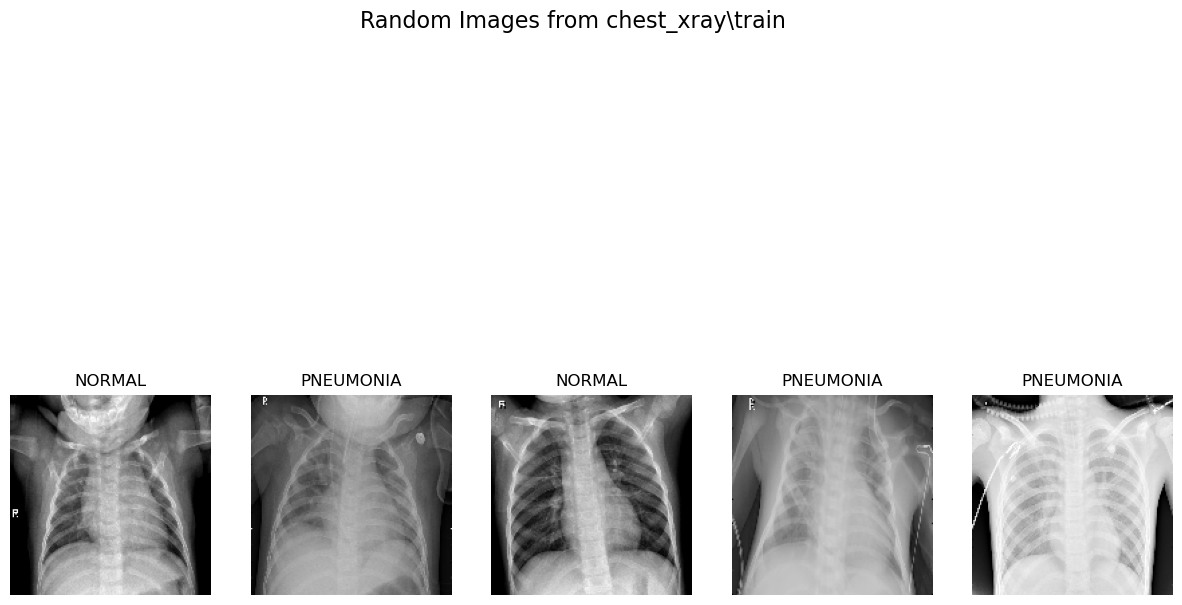

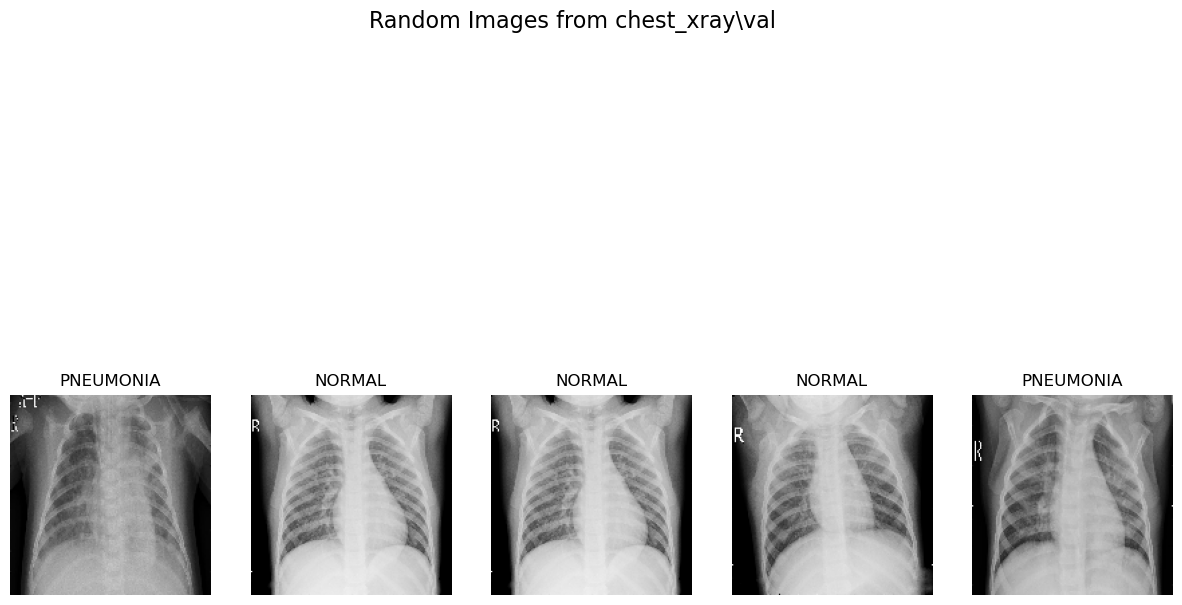

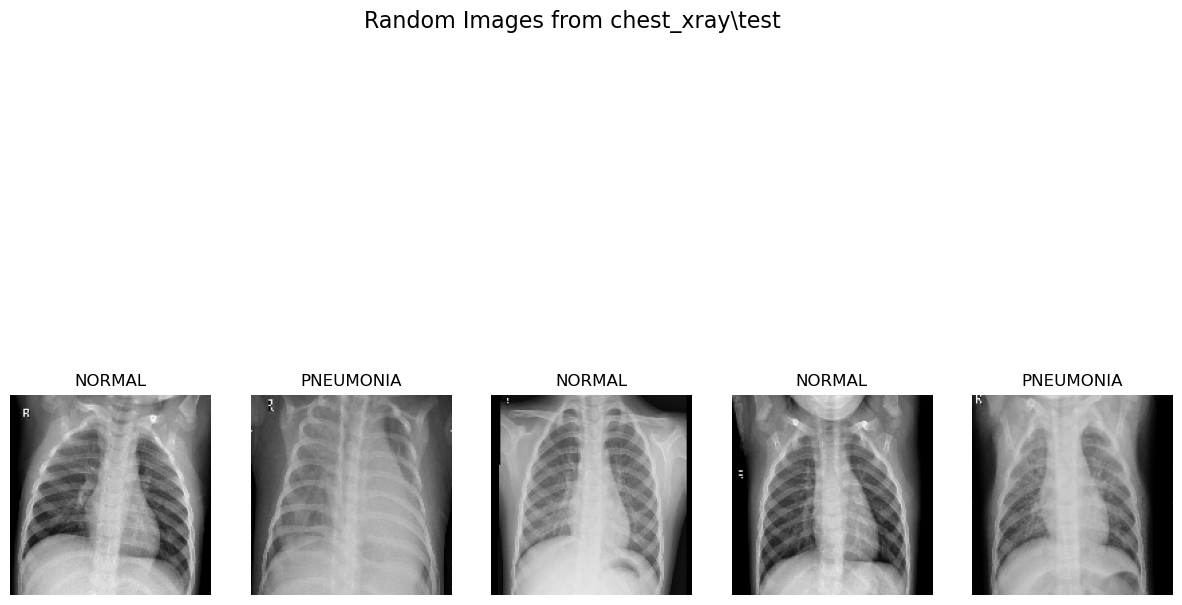

In [8]:
import random
from tensorflow.keras.preprocessing import image

# Function to display random images from a directory
def display_random_images(directory, num_images=5):
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"Random Images from {directory.split('/')[-1]}", fontsize=16)

    for i in range(num_images):
        random_class = random.choice(os.listdir(directory))
        random_image_path = os.path.join(directory, random_class, random.choice(os.listdir(os.path.join(directory, random_class))))
        img = image.load_img(random_image_path, target_size=(img_width, img_height))
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(random_class)
        plt.axis('off')

    plt.show()

# Display random images from train, validation, and test sets
display_random_images(os.path.join(dataset_path, 'train'))
display_random_images(os.path.join(dataset_path, 'val'))
display_random_images(os.path.join(dataset_path, 'test'))


In [9]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [10]:
history_cnn = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10


163/163 [==============================] - 95s 577ms/step - loss: 0.4021 - accuracy: 0.8288 - val_loss: 0.3490 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 106s 651ms/step - loss: 0.2337 - accuracy: 0.9047 - val_loss: 0.8483 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 88s 538ms/step - loss: 0.2114 - accuracy: 0.9122 - val_loss: 0.4442 - val_accuracy: 0.8125
Epoch 4/10
163/163 [==============================] - 88s 537ms/step - loss: 0.1838 - accuracy: 0.9258 - val_loss: 0.3323 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 87s 531ms/step - loss: 0.1677 - accuracy: 0.9365 - val_loss: 1.0672 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 87s 534ms/step - loss: 0.1616 - accuracy: 0.9375 - val_loss: 0.6397 - val_accuracy: 0.6875
Epoch 7/10
163/163 [==============================] - 88s 539ms/step - loss: 0.1429 - accuracy: 0.9454 - val_loss: 0.9246 - val

In [11]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


In [12]:
# Flatten image data for RF model
train_data = np.concatenate([train_generator.next()[0] for _ in range(train_generator.__len__())])
train_labels = np.concatenate([train_generator.next()[1] for _ in range(train_generator.__len__())])

rf_model.fit(train_data.reshape(train_data.shape[0], -1), train_labels)


RandomForestClassifier(random_state=42)

In [14]:
# SVM Model
svm_model = SVC(kernel='linear', random_state=42)

svm_model.fit(train_data.reshape(train_data.shape[0], -1), train_labels)

SVC(kernel='linear', random_state=42)

In [15]:
def evaluate_model(model, generator):
    scores = model.evaluate(generator)
    print(f"{model.__class__.__name__} - {model.metrics_names[1]}: {scores[1] * 100}%")
    return scores[1]

In [18]:
# Evaluate Models
def evaluate_model(model, generator):
    if hasattr(model, 'evaluate'):  # Check if the model has 'evaluate' method
        scores = model.evaluate(generator)
        print(f"{model.__class__.__name__} - {model.metrics_names[1]}: {scores[1] * 100}%")
        return scores[1]
    else:  # For models like RandomForestClassifier
        features = np.concatenate([generator.next()[0] for _ in range(generator.__len__())])
        labels = np.concatenate([generator.next()[1] for _ in range(generator.__len__())])
        accuracy = model.score(features.reshape(features.shape[0], -1), labels)
        print(f"{model.__class__.__name__} - Accuracy: {accuracy * 100}%")
        return accuracy

cnn_accuracy = evaluate_model(cnn_model, test_generator)
rf_accuracy = evaluate_model(rf_model, test_generator)
svm_accuracy = evaluate_model(svm_model, test_generator)


20/20 [==============================] - 5s 235ms/step - loss: 0.4137 - accuracy: 0.8526
Sequential - accuracy: 85.25640964508057%
RandomForestClassifier - Accuracy: 63.141025641025635%
SVC - Accuracy: 58.493589743589745%


In [19]:
predictions_cnn = cnn_model.predict(test_generator)
predictions_cnn = np.round(predictions_cnn)
print("\nCNN Classification Report:")
print(classification_report(test_generator.classes, predictions_cnn))

20/20 [==============================] - 6s 246ms/step

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76       234
           1       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.85      0.84       624



In [20]:
cm_cnn = confusion_matrix(test_generator.classes, predictions_cnn)
print("\nCNN Confusion Matrix:")
print(cm_cnn)


CNN Confusion Matrix:
[[144  90]
 [  2 388]]


In [21]:
# Plotting accuracy graph
algorithms = ['CNN', 'Random Forest', 'SVM']
accuracies = [cnn_accuracy, rf_accuracy, svm_accuracy]

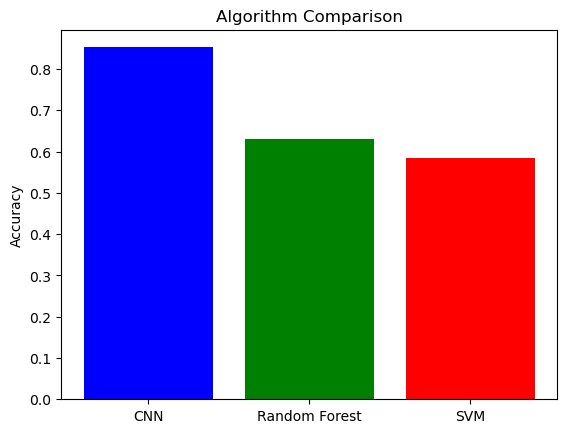

In [22]:
plt.bar(algorithms, accuracies, color=['blue', 'green', 'red'])
plt.ylabel('Accuracy')
plt.title('Algorithm Comparison')
plt.show()

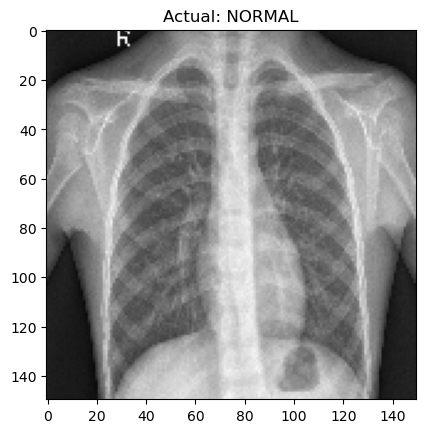

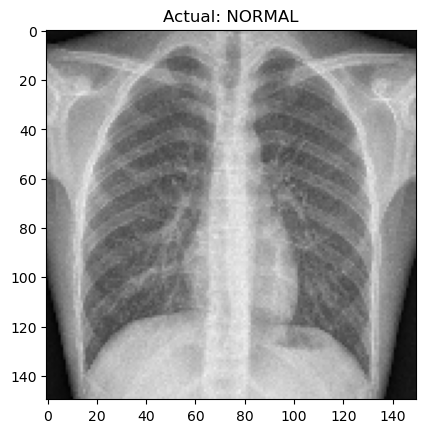

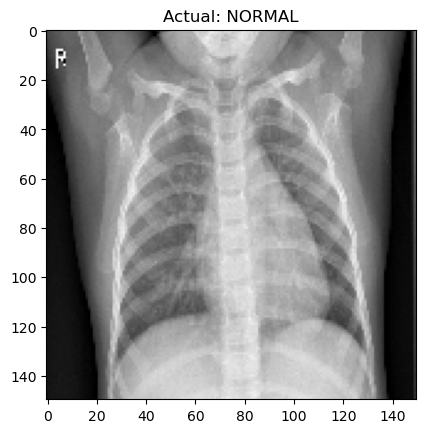

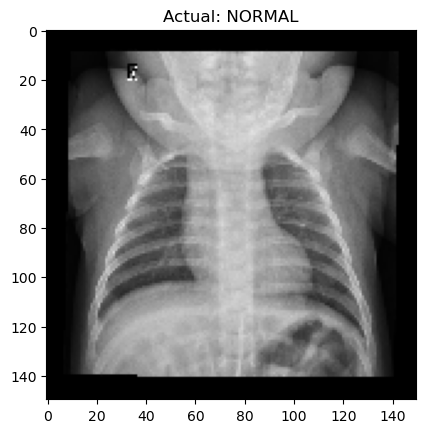

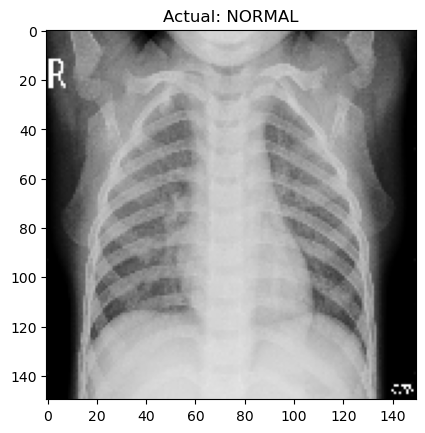

In [23]:
# Show sample images from test set
def show_sample_images(generator, num_images=5):
    class_labels = {v: k for k, v in generator.class_indices.items()}
    for _ in range(num_images):
        batch = generator.next()
        image = batch[0][0]
        label = batch[1][0]
        label_name = class_labels[int(label)]
        
        plt.imshow(image)
        plt.title(f"Actual: {label_name}")
        plt.show()

show_sample_images(test_generator)


In [38]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def upload_and_classify_image(file_path):
    img = load_img(file_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = cnn_model.predict(img_array)
    predicted_class = "Pneumonia" if prediction[0][0] > 0.5 else "Normal"

    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class} (Probability: {prediction[0][0]:.2f})")
    plt.show()



1/1 [==============================] - 0s 34ms/step


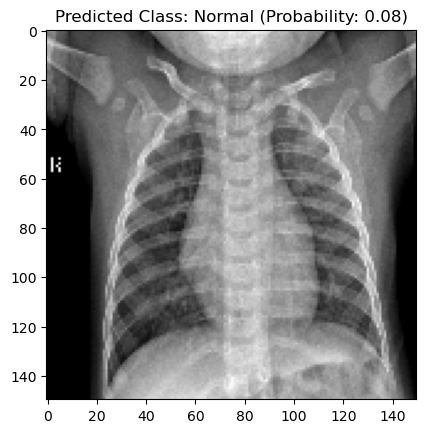

In [43]:


upload_and_classify_image('dataset/chest_xray/train/NORMAL/IM-0207-0001.jpeg')